# CS 3110/5110: Data Privacy
## In-Class Exercise, week of 11/11/2024

In [50]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs3110-data-privacy/raw/main/homework/adult_with_pii.csv')

## Question 1

Implement `age_hist`, which returns a differentially private histogram of ages for ages 0-100 in the `adult` dataset.

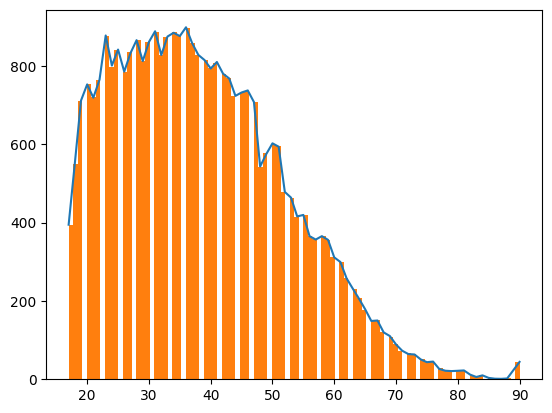

In [51]:
def age_hist(epsilon):
    hist = adult['Age'].value_counts()
    # Sensitivity = 1 because histograms are counting queries
    # Parallel composition applies because it's a histogram.
    return hist.apply(lambda x: laplace_mech(x, 1, epsilon))

plt.plot(age_hist(1.0).sort_index());
plt.hist(adult['Age'], bins=100);

## Question 2

Using the *synthetic representation* of the differentially private histogram from question 1, answer the range query, "how many people are between the ages of 30 and 42?"

In [52]:
# as the range gets bigger, tbe synthetic rep answer gets less accurate
# (The absolute error gets bigger.)
def range_query_synth(syn_rep, a, b):
    total = 0
    for i in range(a, b):
        total += syn_rep[i]
    return total

def between_30_42_syn(epsilon):
    syn_rep = age_hist(epsilon)
    return range_query_synth(syn_rep, 30, 42)
    
print('Synthetic answer:', between_30_42_syn(1.0))
print('True answer:', len(adult[(adult['Age'] >= 30) & (adult['Age'] < 42)]))

Synthetic answer: 10215.855238646003
True answer: 10215


## Question 3

Using the synthetic representation generated by the `age_hist` function, derive a differentially private approximation of the *one-way marginal* for the `Age` column of the `adult` dataset.

In [70]:
def age_marginal(epsilon):
    # A histogram is just probability distravution that doesn't add up to 1.
    # (Also no negative probabilities)
    syn_rep = age_hist(epsilon)
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    return syn_normalized.to_frame(name='probability').reset_index().rename(columns={'index': 'Age'})


marginal = age_marginal(1.0)
print('Sum of marginal probabilities:', np.sum(marginal['probability']))
marginal

Sum of marginal probabilities: 1.0000000000000002


,Age,probability
0,36,0.027582
1,31,0.027278
2,34,0.027185
3,23,0.026961
4,35,0.026939
...,...,...
68,83,0.000206
69,88,0.000005
70,85,0.000101
71,86,0.000014


## Question 4

Using the marginal constructed by `age_marginal`, sample *synthetic ages* from the probability distribution it represents.

In [73]:
def gen_samples(n, marginal):
    return marginal.sample(n=n, replace=True, weights='probability')
    
marginal = age_marginal(1.0)
syn_data = pd.DataFrame(gen_samples(5, marginal), columns=['Age'])
syn_data

,Age
26,21
31,49
1,31
27,19
25,44


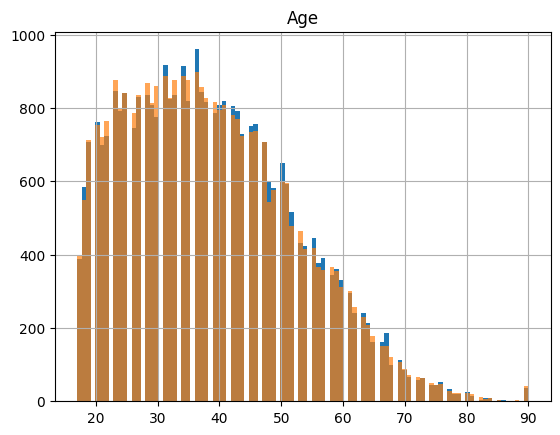

In [59]:
syn_data = pd.DataFrame(gen_samples(len(adult), marginal), columns=['Age'])
syn_data.hist(bins=100)
adult['Age'].hist(alpha=0.7, bins = 100);

## Accuracy of Synthetic Representation

In [60]:
epsilon = 1.0
syn_rep = age_hist(epsilon)

# Query 1: count with 40 <= age < 43
true_answer = len(adult[(adult['Age'] >= 40) & (adult['Age'] < 43)])
print('Q1 percent error, synthetic representation:', 
      pct_error(true_answer, range_query_synth(syn_rep, 40, 43)))

lap_answer = laplace_mech(true_answer, 1, epsilon)
print('Q1 percent error, Laplace mechanism:', 
      pct_error(true_answer, lap_answer))

Q1 percent error, synthetic representation: 0.06984163126544277
Q1 percent error, Laplace mechanism: 0.006019168627582029


In [61]:
# Query 2: count with 25 <= age < 53
true_answer = len(adult[(adult['Age'] >= 25) & (adult['Age'] < 53)])
print('Q2 percent error, synthetic representation:', 
      pct_error(true_answer, range_query_synth(syn_rep, 25, 53)))

lap_answer = laplace_mech(true_answer, 1, epsilon)
print('Q2 percent error, Laplace mechanism:', 
      pct_error(true_answer, lap_answer))

Q2 percent error, synthetic representation: 0.04164485330808807
Q2 percent error, Laplace mechanism: 0.009053332271125156


## Question 5

Which approach gives more accurate answers: the Laplace mechanism or the synthetic representation? Under what conditions is the synthetic representation good, and under what conditions is it not as good?

Accuracy:
- laplace mechansism is best
- Synthetic representation is in the middle (Due to differential privacy noise)
- Synthetic data is worst (Due to additional sampling noise)

When is it good:
- When the range is small, we add together just a few noise samples, so the accuracy is close to the laplace mechanism.
- When the range is big, we add together lots of noise samples, so the accuracy is worse.

## Question 6

Implement a synthetic representation for *two dimensions*: `Age` and `Occupation`.

In [66]:
def age_occupation_hist(epsilon):
    hist = adult[['Age', 'Occupation']].value_counts()
    noisy_hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))
    return noisy_hist#.to_frame().reset_index()

age_occupation_hist(1.0)

Age  Occupation       
19   Other-service        166.164190
37   Craft-repair         154.656813
18   Other-service        155.021131
38   Exec-managerial      146.928193
     Craft-repair         148.470490
                             ...    
72   Craft-repair          -0.479626
71   Tech-support           0.201121
     Machine-op-inspct      0.799184
     Handlers-cleaners     -1.213986
90   Transport-moving       0.666482
Length: 843, dtype: float64

## Question 7

Using the synthetic representation from Question 6, implement functions to calculate the *two-way marginal distribution* and generate synthetic data samples.

In [63]:
def age_occupation_marginal(epsilon):
    syn_rep = age_occupation_hist(epsilon)
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    return syn_normalized.to_frame(name='probability').reset_index()


def gen_samples(n, marginal):
    samples = marginal.sample(n=n, replace=True, weights='probability')
    return samples[['Age', 'Occupation']]

marginal = age_occupation_marginal(1.0)
gen_samples(15, marginal)

,Age,Occupation
105,27,Prof-specialty
8,31,Craft-repair
81,33,Exec-managerial
29,29,Prof-specialty
241,59,Exec-managerial
378,64,Prof-specialty
13,23,Adm-clerical
57,27,Adm-clerical
133,37,Other-service
40,21,Adm-clerical


## Question 8

Generate synthetic data for the Age and Occupation columns by using a two-way marginal as a *conditional distribution*. Use `age_marginal` to generate data for the Age column, then use `age_occupation_marginal` to generate the Occupation column by *conditioning* on the Age column.

In [64]:
def occupation_marginal(epsilon):
    # a histogram is just a probability distribution that doesn't add up to 1
    # (also no negative probabilities)
    syn_rep = adult['Occupation'].value_counts().apply(lambda x: laplace_mech(x, 1, epsilon))
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    return syn_normalized.to_frame(name='probability').reset_index().rename(columns={'index': 'Occupation'})

def one_way_age_occupation(n, epsilon):
    m1 = age_marginal(epsilon/2)
    m2 = occupation_marginal(epsilon/2)

    output = m1.sample(n=n, replace=True, weights='probability')[['Age']]
    output['Occupation'] = list(m2.sample(n=n, replace=True, weights='probability')['Occupation'])
    return output

one_way_age_occupation(10, 1.0)


,Age,Occupation
20,43,Craft-repair
7,30,Adm-clerical
21,22,Machine-op-inspct
2,34,Adm-clerical
15,41,Adm-clerical
49,67,Prof-specialty
31,49,Adm-clerical
3,23,Handlers-cleaners
19,42,Transport-moving
43,60,Machine-op-inspct


In [85]:
def gen_conditional(age, m2):
    conditioned_dist = m2[m2['Age'] == age]
    return conditioned_dist.sample(n=1, weights='probability')['Occupation'].iloc[0]

def gen_age_occupation_conditional(n, epsilon):
    # generate 1-way marginal for age
    m1 = age_marginal(epsilon/2)
    # generate 2-way marginal for age, occupation
    m2 = age_occupation_marginal(epsilon/2)

    # generate ages
    samples = m1.sample(n=n, replace=True, weights='probability')[['Age']]
    # generate occupations conditioned on age
    samples['Occupation'] = [gen_conditional(age, m2) for age in samples['Age']]
    return samples

gen_age_occupation_conditional(15, 1.0)

,Age,Occupation
16,24,Other-service
25,44,Adm-clerical
6,28,Machine-op-inspct
26,21,Adm-clerical
23,46,Adm-clerical
23,46,Prof-specialty
4,35,Transport-moving
15,41,Exec-managerial
3,23,Sales
20,43,Sales
